# QASM -> PyZX interoperability

In [1]:
import os
import sys
import pyzx as zx
from pyzx.pauliweb import compute_pauli_webs
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import qiskit.qasm2 as qasm2

root_folder = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if root_folder not in sys.path:
    sys.path.insert(0, root_folder)

from scripts.runner import runner
from utils.interop_pyzx import pyzx_g_to_simple_g

zx.settings.colors = zx.rgb_colors
%matplotlib widget

This notebook offers an example of how to use ***topologiq*** to perform an algorithmic lattice surgery on QASM circuits.

## Qiskit -> QASM

Let's start by using Qiskit to produce a QASM string that can undergo algorithmic lattice surgery using ***topologiq***. 

The first step is to a Qiskit circuit. In our case, we'll opt for a Steane code.

PyZX does not (yet?) have some options that would be needed for full QASM-PyZX compatibility. The circuit below is the closest to a circuit that loads successfully into PyZX as a canonical Steane code. However, the resulting PyZX circuit is almost-but-also-not-quite correct.

In [2]:
# Thanks [Yilun Zhao](https://github.com/Zhaoyilunnn) for the code and rationale in this block.
def steane_encoding() -> QuantumCircuit:
    qc = QuantumCircuit(10)

    qc.h(0)
    qc.cx(0, 3)
    qc.cx(0, 4)
    qc.cx(0, 5)
    qc.cx(0, 6)
    qc.h(0)

    qc.h(1)
    qc.cx(1, 3)
    qc.cx(1, 4)
    qc.cx(1, 7)
    qc.cx(1, 8)
    qc.h(1)

    qc.h(2)
    qc.cx(2, 3)
    qc.cx(2, 5)
    qc.cx(2, 7)
    qc.cx(2, 9)
    qc.h(2)

    return qc

circuit = steane_encoding()
print(circuit)

     ┌───┐                                   ┌───┐                         
q_0: ┤ H ├──■────■─────────■──────────────■──┤ H ├─────────────────────────
     ├───┤  │    │         │              │  └───┘          ┌───┐          
q_1: ┤ H ├──┼────┼────■────┼────■─────────┼────■─────────■──┤ H ├──────────
     ├───┤  │    │    │    │    │         │    │         │  └───┘     ┌───┐
q_2: ┤ H ├──┼────┼────┼────┼────┼────■────┼────┼────■────┼────■────■──┤ H ├
     └───┘┌─┴─┐  │  ┌─┴─┐  │    │  ┌─┴─┐  │    │    │    │    │    │  └───┘
q_3: ─────┤ X ├──┼──┤ X ├──┼────┼──┤ X ├──┼────┼────┼────┼────┼────┼───────
          └───┘┌─┴─┐└───┘  │  ┌─┴─┐└───┘  │    │    │    │    │    │       
q_4: ──────────┤ X ├───────┼──┤ X ├───────┼────┼────┼────┼────┼────┼───────
               └───┘     ┌─┴─┐└───┘       │    │  ┌─┴─┐  │    │    │       
q_5: ────────────────────┤ X ├────────────┼────┼──┤ X ├──┼────┼────┼───────
                         └───┘          ┌─┴─┐  │  └───┘  │    │    │       
q_6: ───────

The circuit can then be converted into a PyZX circuit, which, in turn, can be converted into a PyZX graph.

In [3]:
# Thanks [Yilun Zhao](https://github.com/Zhaoyilunnn) for the code and rationale in this block.

def qiskit2zx(circuit: QuantumCircuit) -> zx.circuit.Circuit:
    qasm_str = qasm2.dumps(circuit)
    zx_circuit = zx.circuit.Circuit.from_qasm(qasm_str)
    return zx_circuit

zx_circuit = qiskit2zx(circuit)
print(zx_circuit.gates)

zx_graph = zx_circuit.to_graph()

zx.draw(zx_graph, labels=True)  # PyZX produces Jupyter visualisations using D3.
fig_data = zx.draw_matplotlib(zx_graph, labels=True)  # We also need a matplotlib figure to overlay the original ZX-graph over the final visualisation produced by topologiq.

[HAD(0), CNOT(0,3), CNOT(0,4), CNOT(0,5), CNOT(0,6), HAD(0), HAD(1), CNOT(1,3), CNOT(1,4), CNOT(1,7), CNOT(1,8), HAD(1), HAD(2), CNOT(2,3), CNOT(2,5), CNOT(2,7), CNOT(2,9), HAD(2)]


This circuit/graph is quite large and, because it is almost-but-also-not-quite a correct version of a Steane code, it is currently not possible to optimise it *(see next section for optimisation strategies.)*

However, for demonstration purposes, we will run the circuit by topologiq as a means to show topologiq can handle large/unoptimised circuits.

For this, we convert the zx_graph into ***topologiq's*** native graph object, a `simple_graph`, and fed this `simple_graph` to the algorithm.

> **Note.** If the PyZX graph has additional information like phases or Pauli webs, this step will momentarily lose that information. There are other methods not covered in this notebook to recover and apply this information to outputs.

.
SUCCESS!!! Duration: 4.58s. (attempt), 4.58s (total).
Visualisations enabled. For faster runtimes, disable visualisations.


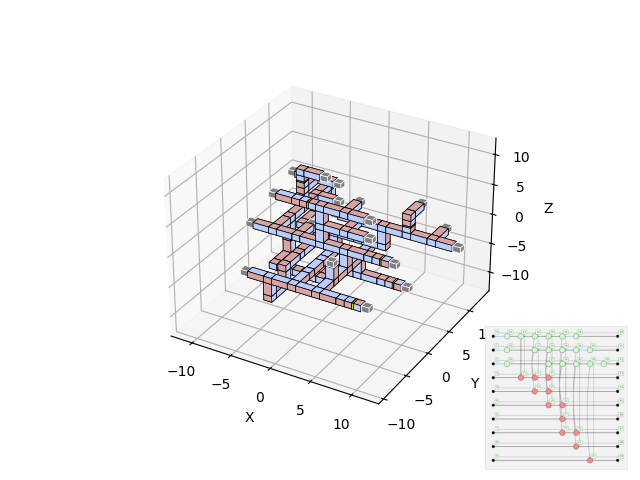

In [5]:
# CONVERT GRAPH TO TOPOLOGIQ'S NATIVE OBJECT
simple_graph = pyzx_g_to_simple_g(zx_graph)

# PARAMS & HYPERPARAMS
circuit_name = "steane_from_qiskit"
visualisation = "final"  # Calls an interactive 3D visualisation at the end. Change to None to deactivate visualisation.
animation = None  # Change to "GIF" or "MP4" for a summary animation of the full process, at significant cost in runtimes due to the need to create and stitch many PNGs together.
VALUE_FUNCTION_HYPERPARAMS = (
    -1,  # Weight for lenght of path
    -1,  # Weight for number of "beams" broken by path
)

kwargs = {
    "weights": VALUE_FUNCTION_HYPERPARAMS,
    "length_of_beams": 9,
}

simple_graph_after_use, edge_pths, lattice_nodes, lattice_edges = runner(
    simple_graph,
    circuit_name,
    min_succ_rate=60,
    strip_ports=False,
    hide_ports=False,
    max_attempts=10,
    stop_on_first_success=True,
    visualise=(visualisation, animation),
    log_stats=False,
    debug=False,
    fig_data=fig_data,
    **kwargs
)

## Non-descript QASM -> PyZX with optimisation

We'll now switch to a non-descript QASM file written by hand. This non-descript QASM file can be simplified/optimised more easily than the circuit in the previous section.

Let's start by loading a compressed QASM file.

In [6]:
# Thanks [Kabir Dubey](https://github.com/KabirDubey) for the QASM file and code/rationale in this block. 

qasm_file_path = str(os.path.join(root_folder, "assets/graphs", "steane_code_compressed.qasm"))

try:
    zx_circuit = zx.Circuit.from_qasm_file(qasm_file_path)
except Exception as e:
    with open(qasm_file_path, "r") as f:
        qasm_str = f.read()
    zx_circuit = zx.qasm(qasm_str)

zx_graph = zx_circuit.to_graph()

zx.draw(zx_graph, labels=True)  # PyZX produces Jupyter visualisations using D3.
fig_data = zx.draw_matplotlib(zx_graph, labels=True)  # We also need a matplotlib figure to overlay the original ZX-graph over the final visualisation produced by topologiq.

Now, let's simplify the graph a little using PyZX native functions.

In [7]:
# Thanks [Purva Thakre](https://github.com/purva-thakre) for research into and ideas into QASM/PyZX simplifying strategies, which informed choices in this block.

# Make a copy to avoid over-writing the imported circuit.
zx_graph_optimised_1 = zx_graph.copy()

# Auto-simplify using spider fusion method.
zx.simplify.spider_simp(zx_graph_optimised_1)

zx.draw(zx_graph_optimised_1, labels=True)  # Jupyter visualisations using D3.
fig_data = zx.draw_matplotlib(zx_graph_optimised_1, labels=True)  # Fig to overlay in final vis.

After, we can proceed to running the circuit by ***topologiq***. 

> **Note.** If the PyZX graph has additional information like phases or Pauli webs, this step will momentarily lose that information. There are other methods not covered in this notebook to recover and apply this information to outputs.

.
SUCCESS!!! Duration: 2.20s. (attempt), 2.20s (total).
Visualisations enabled. For faster runtimes, disable visualisations.


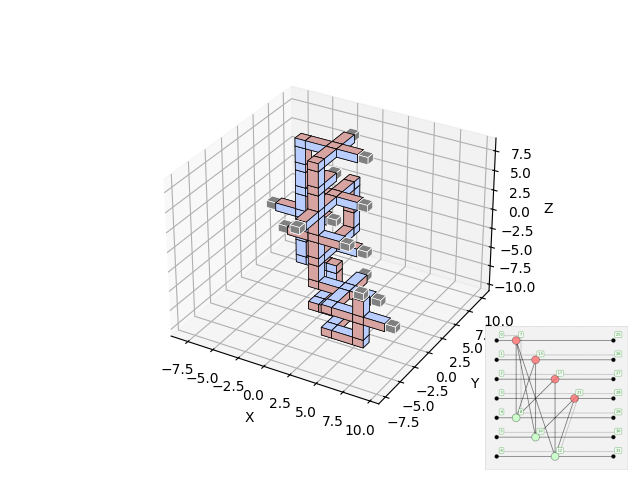

In [8]:
# CONVERT GRAPH TO TOPOLOGIQ'S NATIVE OBJECT
simple_graph = pyzx_g_to_simple_g(zx_graph_optimised_1)

# PARAMS & HYPERPARAMS
circuit_name = "steane_optimised_1"
visualisation = "final"  # Calls an interactive 3D visualisation at the end. Change to None to deactivate visualisation.
animation = None  # Change to "GIF" or "MP4" for a summary animation of the full process, at significant cost in runtimes due to the need to create and stitch many PNGs together.
VALUE_FUNCTION_HYPERPARAMS = (
    -1,  # Weight for lenght of path
    -1,  # Weight for number of "beams" broken by path
)

kwargs = {
    "weights": VALUE_FUNCTION_HYPERPARAMS,
    "length_of_beams": 9,
}

simple_graph_after_use, edge_pths, lattice_nodes, lattice_edges = runner(
    simple_graph,
    circuit_name,
    min_succ_rate=80,
    strip_ports=False,
    hide_ports=False,
    max_attempts=10,
    stop_on_first_success=True,
    visualise=(visualisation, animation),
    log_stats=False,
    debug=False,
    fig_data=fig_data,
    **kwargs
)

We can simplify the circuit even more using ZX-rules manually.

PyZX does not have a method to reduce the number of boundaries in an existing graph (does it?). However, we can visualise Pauli webs to get a better understanding of the flows inside this graph. Essentially, this will show how all webs flow from a boundary to the other end of the charts on all connecting nodes running from that boundary. 

As per [Craig Gidney in StackExchange](https://quantumcomputing.stackexchange.com/questions/40893/what-is-a-stabilizer-flows-in-qec) (I think that's him), we can more or less ignore webs/flows that go straight through the first node they touch into the opposite end of the same qubit line.

In [9]:
# Thanks [Purva Thakre](https://github.com/purva-thakre) for research into and ideas into QASM/PyZX simplifying strategies, which informed choices in this block.
zx_graph_optimised_2 = zx_graph_optimised_1.copy()

# Get the IDs for end boundaries to calculate webs
boundary_ids = [key for key, value in zx_graph_optimised_2.types().items() if value == 0]
end_boundary_ids = boundary_ids[zx_graph_optimised_2.qubit_count() :]

# Calculate and visualise webs
order, zwebs, xwebs = compute_pauli_webs(zx_graph_optimised_2)
for id in end_boundary_ids:
    zx.draw(zx_graph_optimised_2, labels=True, pauli_web=xwebs[id])
    zx.draw(zx_graph_optimised_2, labels=True, pauli_web=zwebs[id])

# Eliminate any boundary where the flow can be ignored.
for pair in [(0, 14), (1, 15), (2, 16), (3, 17)]:
    zx_graph_optimised_2.remove_vertex(pair[0])

for pair in [(4, 18), (5, 19), (6, 20)]:
    zx_graph_optimised_2.add_edge(zx_graph_optimised_2.edge(pair[1], pair[0]))
    zx_graph_optimised_2.remove_vertex(pair[1])

zx_graph_optimised_2.normalize()
zx.draw(zx_graph_optimised_2, labels=True)  # Jupyter visualisations using D3.
fig_data = zx.draw_matplotlib(zx_graph_optimised_2, labels=True)  # Fig to overlay in final vis.

# Could this be achieved using a simpler rationale? 
# Eg. Move boundary past node, then fuse?
#for pair in [(0, 14), (1, 15), (2, 16), (3, 17)]:
#    zx_graph_optimised_2.add_edge(zx_graph_optimised_2.edge(pair[0], pair[1]))
#    zx_graph_optimised_2.remove_vertex(pair[0])
#
#for pair in [(4, 18), (5, 19), (6, 20)]:
#    zx_graph_optimised_2.add_edge(zx_graph_optimised_2.edge(pair[1], pair[0]))
#    zx_graph_optimised_2.remove_vertex(pair[1])



Let's now run this final optimised version by ***topologiq***.

.
SUCCESS!!! Duration: 0.76s. (attempt), 0.76s (total).
Visualisations enabled. For faster runtimes, disable visualisations.


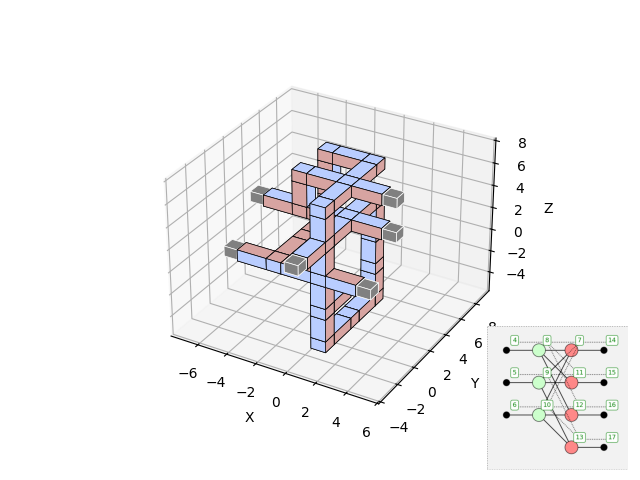

In [12]:
# CONVERT GRAPH TO TOPOLOGIQ'S NATIVE OBJECT
simple_graph = pyzx_g_to_simple_g(zx_graph_optimised_2)

# PARAMS & HYPERPARAMS
circuit_name = "steane_optimised_2"
visualisation = "final" # # Calls an interactive 3D visualisation at the end. Change to None to deactivate visualisation.
animation = None  # Change to "GIF" or "MP4" for a summary animation of the full process, at significant cost in runtimes due to the need to create and stitch many PNGs together.
VALUE_FUNCTION_HYPERPARAMS = (
    -1,  # Weight for lenght of path
    -1,  # Weight for number of "beams" broken by path
)

kwargs = {
    "weights": VALUE_FUNCTION_HYPERPARAMS,
    "length_of_beams": 9,
}

simple_graph_after_use, edge_pths, lattice_nodes, lattice_edges = runner(
    simple_graph,
    circuit_name,
    min_succ_rate=60,
    strip_ports=False,
    hide_ports=False,
    max_attempts=10,
    stop_on_first_success=True,
    visualise=(visualisation, animation),
    log_stats=False,
    debug=False,
    fig_data=fig_data,
    **kwargs
)

And let's print out all the objects returned by ***topologiq*** so that we can inspect them closer.

In [13]:
print("\nInput graph:")
for k, v in simple_graph_after_use.items():
    print(f"{k}:{v}")

if edge_pths:
    print("\nEdge paths:")
    for k, v in edge_pths.items():
        print(f"{k}:{v}")
        
if lattice_nodes:
    print("\nCubes in final output:")
    for k, v in lattice_nodes.items():
        print(f"{k}:{v}")

if lattice_edges:
    print("\nPipes in final output:")
    for k, v in lattice_edges.items():
        print(f"{k}:{v}")


Input graph:
nodes:[(4, 'O'), (5, 'O'), (6, 'O'), (7, 'X'), (8, 'Z'), (9, 'Z'), (10, 'Z'), (11, 'X'), (12, 'X'), (13, 'X'), (14, 'O'), (15, 'O'), (16, 'O'), (17, 'O')]
edges:[((4, 8), 'SIMPLE'), ((5, 9), 'SIMPLE'), ((6, 10), 'SIMPLE'), ((7, 8), 'SIMPLE'), ((7, 9), 'SIMPLE'), ((7, 10), 'SIMPLE'), ((7, 14), 'SIMPLE'), ((8, 11), 'SIMPLE'), ((8, 12), 'SIMPLE'), ((9, 13), 'SIMPLE'), ((9, 11), 'SIMPLE'), ((10, 13), 'SIMPLE'), ((10, 12), 'SIMPLE'), ((11, 15), 'SIMPLE'), ((12, 16), 'SIMPLE'), ((13, 17), 'SIMPLE')]

Edge paths:
(6, 10):{'src_tgt_ids': (10, 6), 'pth_coordinates': [(1, 0, 0), (0, 0, 0), (3, 0, 0), (2, 0, 0)], 'pth_nodes': [((0, 0, 0), 'xzx'), ((1, 0, 0), 'ozx'), ((3, 0, 0), 'ooo')], 'edge_type': 'SIMPLE'}
(7, 10):{'src_tgt_ids': (10, 7), 'pth_coordinates': [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3)], 'pth_nodes': [((0, 0, 0), 'xzx'), ((0, 0, 1), 'xzo'), ((0, 0, 3), 'xzz')], 'edge_type': 'SIMPLE'}
(10, 13):{'src_tgt_ids': (10, 13), 'pth_coordinates': [(0, 0, 0), (-2, 0, 0), (-1,

Finally, for memory's sake, let's shut down any open plots.

In [14]:
from matplotlib.pyplot import close
close()